In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy
import evo_etc

In [2]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [3]:
def boot_strap_ci(data,sampling_time=1000):
    # data is a matrix, we are going to get cis for all columns
    data = np.array(data)
    def _ci_of_a_column(lst):
        means = []
        for _ in range(sampling_time):
            sampled_index = np.random.randint(0,len(lst),size=len(lst)) 
            means.append(np.mean(lst[sampled_index]))
        means.sort()
        return [means[24],means[974]]
    
    cis = list()
    for i in range(data.shape[1]):
        cis.append(_ci_of_a_column(data[:,i]))
    
    return np.array(cis)

In [4]:
!less ../data/enzyme_uniprot_gene_name.csv|grep ADE5

P07244,ADE5,7


In [5]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

### Visualize models from posterior distribution

In [125]:
model = pickle.load(open('../results/smcevo_gem_three_conditions_save_all_particles.pkl','rb'))

In [134]:
def plot_lines_prior_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental',zorder=1)
    print(np.var(dfae_batch['r_ae'])*0.15)
    for item in model.simulated_data_t0: 
        plt.plot(dfae_batch.index,item['ran'],zorder=0,color='#1f78b4')
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [135]:
def plot_lines_prior_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental',zorder=1)
    
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    for item in model.simulated_data_t0: 
        plt.plot(ts,item['ran'],zorder=0,color='#1f78b4')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [136]:
def plot_lines_prior_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])

    #rs0 = np.array(rs0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        if i<2: continue
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental',zorder=1)
        for j,r in enumerate(rs0):
            plt.plot(dfchemo.index,r[i*6:(i+1)*6],color='#1f78b4',zorder=0)
        print(j)
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

In [137]:
model.simulated_data_t0= model.all_simulated_data[0:100]

0.0018241406250000005


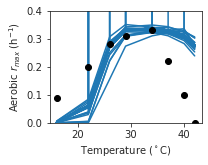

In [138]:
plot_lines_prior_ae(model,outname='../figures/aerobic_prior_lines.pdf')

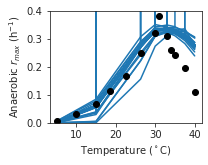

In [139]:
plot_lines_prior_an(model,outname='../figures/anaerobic_prior_lines.pdf')

4.260765416666666
99


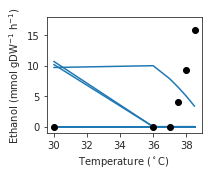

In [140]:
plot_lines_prior_chemostat(model,prefix='../figures/chemostat_prior_lines')

In [141]:
!pwd

/mnt/scratch/jakobpp/BayesianGEM/code


In [142]:
model.simulated_data = model.all_simulated_data[-100:-1]

In [143]:
def plot_last_population_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental')
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    rs0 = list()
    rs  = list()
    for item in model.simulated_data_t0: rs0.append(item['rae'])
    for item in model.simulated_data: rs.append(item['rae'])

    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    
    plt.plot(dfae_batch.index,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(dfae_batch.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(dfae_batch.index,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(dfae_batch.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [145]:
def plot_last_population_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental')
    
    
    rs0 = list() # prior
    rs = list()  # posterior
    for item in model.simulated_data: rs.append(item['ran'])
    for item in model.simulated_data_t0:rs0.append(item['ran'])
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    print(np.var(dfan_batch.loc[ts,'r_an'])*0.15)
    
    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    plt.plot(ts,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(ts,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(ts,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(ts,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    plt.ylim([0, np.max(y0[1,:]*2)])
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    #plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [146]:
def plot_last_population_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    rs  = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])
    for item in model.simulated_data: rs.append(item['chemostat'])

    #rs0 = np.array(rs0)
    #yt0 = np.mean(rs0,axis=0)
    #yerrt0 = np.std(rs0,axis=0)
    
    #rs = np.array(rs)
    #yt = np.mean(rs,axis=0)
    #yerrt = np.std(rs,axis=0)
    rs0 = np.array(rs0)
    yt0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    yt = np.percentile(rs,[5,50,95],axis=0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental')
        y0 = yt0[:,i*6:(i+1)*6]
        #yerr0 = yerrt0[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y0[1,:],color='#1f78b4',label='prior')
        plt.fill_between(dfchemo.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
        
        y = yt[:,i*6:(i+1)*6]
        #yerr = yerrt[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y[1,:],color='#fc8d59',label='posterior')
        plt.fill_between(dfchemo.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
        
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

In [147]:
def plot_legend_growth():
    plt.figure(figsize=(3,2.4))
    plt.scatter([],[],color='k',label='Exp')
    
    plt.plot([],[],color='#1f78b4',label='Prior')
    plt.fill_between([],[],[],alpha=0.8,color='#1f78b4')
    
    plt.plot([],[],color='#fc8d59',label='Posterior')
    plt.fill_between([],[],[],alpha=0.8,color='#fc8d59')
    
    plt.legend(loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/prior_posterior_legend.pdf',transparent=True)
    plt.show()

0.0018241406250000005


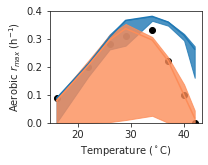

In [148]:
plot_last_population_ae(model,outname='../figures/aerobic_prior_posterior.pdf')

0.0017126156249999997


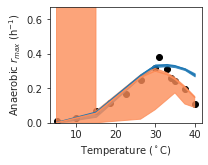

In [149]:
plot_last_population_an(model,outname='../figures/anaerobic_prior_posterior.pdf')

4.260765416666666


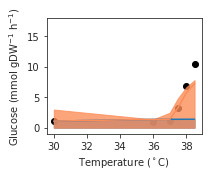

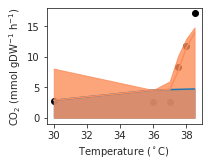

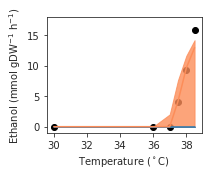

In [150]:
plot_last_population_chemostat(model,prefix='../figures/chemostat_prior_posterior')

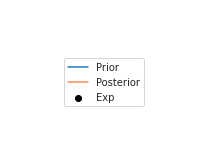

In [70]:
 plot_legend_growth()

### Visualize particle population

In [ ]:
def combine_dataframes_for_models(df_dict):
    # augmented_df_list =[ df.assign(model = lambda df: label)  for df, label in zip(df_list, index)]
    augmented_df_dict = {label: df.copy() for label, df in df_dict.items()}
    print("Copying done")
    for label, df in augmented_df_dict.items():
        df["model"] = label
        df["period"] = "Intermediate"
        df.loc[:128,"period"] = "Prior"
        df.loc[df["r2"] > 0.9,"period"] = 'Posterior'
        df.reset_index()
    print("Labelling done")
    return pd.concat(augmented_df_dict.values(), ignore_index=True)

In [87]:
sample_particle = model.all_particles[0]

In [88]:
type(sample_particle)

dict

In [100]:
reference_model = pickle.load(open("../results/smcabc_gem_three_conditions_save_all_particles.pkl",'rb'))

In [94]:
sample_key = 'O13525_Tm'

In [96]:
sample_particle[sample_key]

In [112]:
def build_a_dataframe_for_all_particles(results, convert_results=False):
    columns = list(results.all_particles[0].keys())
    columns.sort()

    data = list()
    for p in results.all_particles:
        if convert_results:
            p_refined = evo_etc.convert_to_raw_particle(p)
        else:
            p_refined = p
        data.append([p_refined[k] for k in columns])
    df = pd.DataFrame(data=data,columns=columns)
    df['r2'] = results.all_distances
    print(df.shape)
    
    # Remove samples with a R2 score smaller than -3
    df['r2'] = -df['r2']
    sel_index = df.index[df['r2']>-3]
    df = df.loc[sel_index,:]
    print(df.shape)

    return df

In [107]:
def perform_pca_on_parameters(df):
    # 1. normalize all columns to a standard normal distribution
    X, y = df.values[:,:-1], df.values[:,-1]
    X_n = np.zeros_like(X)
    
    for i in range(X_n.shape[1]): X_n[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    pca = PCA(n_components=2)
    PCS = pca.fit_transform(X_n)
    print(pca.explained_variance_ratio_)
    return PCS,pca.explained_variance_ratio_

def perform_pca_on_parameters(df):
    # 1. normalize all columns to a standard normal distribution
    X, y, model, period = df.values[:,:-3], df.values[:,-3], df.values[:,-2], df.values[:,-1]
    X_n = np.zeros_like(X)    
    for i in range(X_n.shape[1]): X_n[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    pca = PCA(n_components=2)
    PCS = pca.fit_transform(X_n)
    print(pca.explained_variance_ratio_)
    return PCS,pca.explained_variance_ratio_

In [104]:
def combine_dataframes_for_models(df_dict):
    # augmented_df_list =[ df.assign(model = lambda df: label)  for df, label in zip(df_list, index)]
    augmented_df_dict = {label: df.copy() for label, df in df_dict.items()}
    print("Copying done")
    for label, df in augmented_df_dict.items():
        df["model"] = label
        df["period"] = "Intermediate"
        df.loc[:128,"period"] = "Prior"
        df.loc[df["r2"] > 0.9,"period"] = 'Posterior'
        df.reset_index()
    print("Labelling done")
    return pd.concat(augmented_df_dict.values(), ignore_index=True)
    

In [113]:
df_theta = build_a_dataframe_for_all_particles(model, convert_results=True)
df_reference = build_a_dataframe_for_all_particles(reference_model)

(6750, 2293)
(6147, 2293)
(21504, 2293)
(21058, 2293)


In [114]:
combined_df = combine_dataframes_for_models({'bayesian' : df_reference, 'evolution': df_theta})

Copying done
Labelling done


In [115]:
PCS,EV = perform_pca_on_parameters(combined_df)

[0.07613013 0.00849685]


In [118]:
combined_df

,O13525_Tm,O13525_Topt,O13525_dCpt,P00044_Tm,P00044_Topt,P00044_dCpt,P00045_Tm,P00045_Topt,P00045_dCpt,P00127_Tm,...,Q99258_dCpt,Q99312_Tm,Q99312_Topt,Q99312_dCpt,Q99321_Tm,Q99321_Topt,Q99321_dCpt,r2,model,period
0,323.383375,316.376290,-6282.961180,319.536771,303.624184,-6485.608261,330.836389,323.643022,-4013.327405,323.022442,...,-8293.810880,334.286147,329.997339,-6350.806882,321.661931,320.956646,-4880.532399,-1.281283,bayesian,Prior
1,323.225380,295.237549,-7308.050079,320.498313,318.548389,-7655.123502,330.136310,317.070954,-7383.973179,322.926765,...,-7862.861663,326.575802,299.750337,-6090.819228,328.073013,304.599145,-4868.482107,-0.651635,bayesian,Prior
2,317.676145,300.966752,-5635.864994,315.316548,297.833563,-9400.779200,329.843124,306.963812,-7164.439107,330.716702,...,-10490.758989,317.922504,300.270472,-2994.035078,326.335111,301.511659,-10053.456135,-1.951493,bayesian,Prior
3,317.902032,299.642782,-7449.385914,323.187804,293.599385,-7362.945481,321.493197,321.158309,-7024.974895,322.485356,...,-6567.463080,315.149925,306.500383,-4415.126780,324.659219,316.925327,-4196.536122,-1.392736,bayesian,Prior
4,321.567154,300.674084,-8399.496403,322.737474,314.142100,-7360.059564,337.422262,333.557588,-7726.017234,318.537663,...,-4017.897784,320.487330,290.088160,-3672.930047,328.996384,307.497107,-2400.047056,-1.902613,bayesian,Prior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27200,327.366486,321.296298,-5974.809148,321.928354,313.313639,-10438.955642,324.949918,311.821975,-5355.490822,325.080898,...,-6839.365293,323.694039,306.877547,-5146.794671,325.972039,317.668715,-6089.503792,0.908160,evolution,Posterior
27201,327.366486,321.296298,-5974.809148,321.928354,313.313639,-10438.955642,324.949918,311.821975,-5355.490822,325.080898,...,-6839.365293,323.694039,306.877547,-5146.794671,324.429633,317.668715,-6089.503792,0.953386,evolution,Posterior
27202,331.444192,320.775587,-5846.432184,321.965572,313.311729,-10201.984569,325.063705,311.910532,-5344.776799,325.081315,...,-6938.335992,323.686019,307.395799,-5146.588332,324.259700,317.660201,-6096.258364,-0.886124,evolution,Intermediate
27203,327.369057,320.775587,-5846.432184,321.965572,313.311729,-10201.984569,325.063705,311.910532,-5344.776799,325.081315,...,-6938.335992,323.686019,307.395799,-5146.588332,324.259700,317.660201,-6096.258364,0.954148,evolution,Posterior


(21058,)
(6147,)


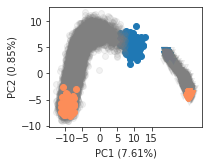

In [122]:
# y = combined_df.values[:,-1]
# plt.figure(figsize=(3.,2.4))

# plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
# plt.scatter(PCS[:128,0],PCS[:128,1],color='#1f78b4',label='Prior')
# plt.scatter([],[],color='grey',alpha=0.2,label='Intermediate')
# plt.scatter(PCS[y>0.9,0],PCS[y>0.9,1],color='#fc8d59',label='Posterior')

# plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
# plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
# plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
# plt.xticks(np.arange(-10,20,5))
# plt.tight_layout()
# #plt.savefig('../figures/pca.pdf')
# plt.savefig('../figures/pca.png',dpi=300)
# plt.show()
y = combined_df.values[:,-3]
period = combined_df.values[:,-1]
model_name = combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}
combined_index = ['bayesian', 'evolution']
plt.figure(figsize=(3.,2.4))
markers = ["o","v","^","<"]
marker_dict = {label: marker for label, marker in zip(combined_index, markers)}
for label in combined_index:
    label_idxs = np.nonzero(model_name == label)[0]
    marker = marker_dict[label]
    this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
    print(label_idxs.shape)
    # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
    # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
    plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],color='#1f78b4',label='Prior', marker=marker)
    plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                color='grey',alpha=0.1,label='Intermediate',marker=marker)
    plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                color='#fc8d59',label='Posterior',marker=marker)
plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
# plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
plt.xticks(np.arange(-10,20,5))
plt.tight_layout()
#plt.savefig('../figures/pca.pdf')
plt.savefig('../figures/pca.png',dpi=300)
plt.show()

In [123]:
marker_dict

{'bayesian': 'o', 'evolution': 'v'}

# Note the thesholded convergence to the solution

In [128]:
model.min_epsilon

-0.9

Text(0.5, 0, 'Generation')

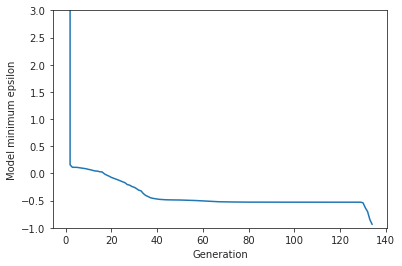

In [131]:
plt.plot(model.epsilons)
plt.ylim([-1,3])
plt.ylabel('Model minimum epsilon')
plt.xlabel('Generation')